In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import re
from pathlib import Path
import SimpleITK as sitk
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
def normalize(img):
    max_value = img.max()
    min_value = img.min()
    
    return (img - min_value) / (max_value - min_value + 1e-8)

def image_pad_crop(img, mask, size, margin=1):
    if img.ndim == 3 and img.shape[2] == 1:
        non_black_flat = img[:,:,0] > 0
    elif img.ndim == 2:
        non_black_flat = img > 0
    else:
        non_black_flat = np.sum(img, axis=-1) > 0 if img.ndim == 3 else np.sum(img, axis=0) > 0 
        
    coords = np.argwhere(non_black_flat)

    if len(coords) == 0:
        if img.ndim == 3: 
            h, w, _ = img.shape
        else: 
            h, w = img.shape
        center_y, center_x = h // 2, w // 2
    else:
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)

        if img.ndim == 3:
            h, w, _ = img.shape
        else:
            h, w = img.shape
            
        y_min = max(0, y_min - margin)
        x_min = max(0, x_min - margin)
        y_max = min(h - 1, y_max + margin)
        x_max = min(w - 1, x_max + margin)
        
        center_y = (y_min + y_max) // 2
        center_x = (x_min + x_max) // 2

    half_size = size // 2
    crop_start_y = center_y - half_size
    crop_end_y = center_y + half_size
    crop_start_x = center_x - half_size
    crop_end_x = center_x + half_size

    if img.ndim == 3: 
        img_result = np.zeros((size, size, img.shape[2]), dtype=img.dtype)
    else: 
        img_result = np.zeros((size, size), dtype=img.dtype)
        
    mask_result = np.zeros((size, size), dtype=mask.dtype)

    src_start_y = max(0, crop_start_y)
    src_end_y = min(h, crop_end_y) 
    src_start_x = max(0, crop_start_x)
    src_end_x = min(w, crop_end_x) 
    
    dest_start_y = max(0, -crop_start_y)
    dest_end_y = dest_start_y + (src_end_y - src_start_y)
    dest_start_x = max(0, -crop_start_x)
    dest_end_x = dest_start_x + (src_end_x - src_start_x)

    img_result[dest_start_y:dest_end_y, dest_start_x:dest_end_x] = img[src_start_y:src_end_y, src_start_x:src_end_x]
    mask_result[dest_start_y:dest_end_y, dest_start_x:dest_end_x] = mask[src_start_y:src_end_y, src_start_x:src_end_x]
    
    return img_result, mask_result

class BraTSDataset(Dataset):
    def __init__(self, data_list, transform=None, out_size=256):
        self.data_list = data_list
        self.transform = transform
        self.out_size = out_size
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        z_current, img_path, mask_path = self.data_list[idx]
        
        full_image_volume = sitk.GetArrayFromImage(sitk.ReadImage(img_path)) 
        full_mask_volume = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

        image_current = full_image_volume[z_current]
        mask_data = full_mask_volume[z_current]

        image_current_norm = normalize(image_current)
        combined_image_3channel = np.stack([image_current_norm, image_current_norm, image_current_norm], axis=-1)

        image_new, mask_new = image_pad_crop(combined_image_3channel, mask_data, self.out_size)
        
        make_t = self.transform(image=image_new, mask=mask_new)
        image_tensor = make_t['image']
        mask_tensor = make_t['mask']
        
        return image_tensor.float(), mask_tensor.float().unsqueeze(0)

In [4]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.7),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=0, p=0.7),
    A.ElasticTransform(alpha=120, sigma=120 * 0.09, alpha_affine=120 * 0.08, p=0.2),
    A.GaussNoise(var_limit=(0.001, 0.01), p=0.4),
    ToTensorV2(),
])

test_transform = A.Compose([
    ToTensorV2(),
])

def create_dataloader(batch_size=8, threshold=10):
    test_list_path = '/data1/BraTS/test_files.csv'

    df = pd.read_csv(test_list_path)

    test_code_list = []
    for fname in df['filename']:
        test_num = re.search(r'BraTS-MEN-RT-([0-9]{4})', fname).group(1)
        test_code_list.append(test_num)
        
    data_path = '/data1/kerter/BraTS/Preprocessing/train/Normalize'

    base_path = Path(data_path)

    img_path = base_path / 'img'
    mask_path = base_path / 'mask'

    img_list = sorted(img_path.iterdir())
    mask_list = sorted(mask_path.iterdir())

    train_data_list, test_data_list = [], []

    for img_path, mask_path in zip(img_list, mask_list):
        mask = sitk.ReadImage(mask_path)
        mask_data = sitk.GetArrayFromImage(mask)
        
        code = re.search(r'([0-9]{4}).nii.gz', mask_path.name).group(1)
        
        for z, mask_slice in enumerate(mask_data):
            if mask_slice.sum() >= threshold:
                if code in test_code_list:
                    test_data_list.append((z, img_path, mask_path))
                else:
                    train_data_list.append((z, img_path, mask_path))
    
    train_dataset = BraTSDataset(train_data_list, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
    
    test_dataset = BraTSDataset(test_data_list, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)
    
    return train_loader, test_loader

In [5]:
train_loader, test_loader = create_dataloader(batch_size=16)

In [ ]:
import torch
import torch.nn as nn
import timm

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels_decoder, in_channels_skip, out_channels, dropout_p=0.2):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.conv_block = ConvBlock(in_channels_decoder + in_channels_skip, out_channels)

        self.dropout = nn.Dropout2d(p=dropout_p)

    def forward(self, x_decoder, x_skip):
        x_decoder = self.upsample(x_decoder)

        x = torch.cat([x_decoder, x_skip], dim=1) # dim=1은 채널 차원

        x = self.conv_block(x)

        x = self.dropout(x)
        
        return x

class CustomModel(nn.Module):
    def __init__(self, encoder_name='resnet50', pretrained=True, classes=1, dropout_rate=0.3):
        super().__init__()
        self.encoder = timm.create_model(encoder_name, pretrained=pretrained, features_only=True)
        self.encoder_channels = self.encoder.feature_info.channels()
        
        self.dropout_enc = nn.Dropout2d(p=dropout_rate)

        self.decoder5 = DecoderBlock(self.encoder_channels[4], self.encoder_channels[3], 512, dropout_p=dropout_rate) # From Layer4 to Layer3 Skip
        self.decoder4 = DecoderBlock(512, self.encoder_channels[2], 256, dropout_p=dropout_rate) # From Layer3 to Layer2 Skip
        self.decoder3 = DecoderBlock(256, self.encoder_channels[1], 128, dropout_p=dropout_rate) # From Layer2 to Layer1 Skip
        self.decoder2 = DecoderBlock(128, self.encoder_channels[0], 64, dropout_p=dropout_rate) # From Layer1 to Conv1_relu/stem Skip
        
        self.upsample_final = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

        self.final_dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        encoder_outputs = self.encoder(x)

        x = self.dropout_enc(encoder_outputs[4])

        d5 = self.decoder5(x, encoder_outputs[3])
        d4 = self.decoder4(d5, encoder_outputs[2])
        d3 = self.decoder3(d4, encoder_outputs[1])
        d2 = self.decoder2(d3, encoder_outputs[0])
        
        x = self.upsample_final(d2)

        x = self.final_dropout(x)
        output = self.final_conv(x)
        
        return output

In [ ]:
# <셀 1>
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import segmentation_models_pytorch as smp

# 기본 설정
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'
THRESHOLD = 0.5

print(f"사용 장치: {DEVICE}")

사용 장치: cuda:1


In [ ]:
def train_one_epoch(model, loader, optimizer, scheduler, criterion, device):
    model.train()
    total_epoch_loss, total_epoch_iou, total_epoch_dice = 0.0, 0.0, 0.0
    num_batches = len(loader)

    for i, (images, masks) in enumerate(loader):
        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        
        with torch.no_grad():
            probs = torch.sigmoid(logits)
            pred_masks = (probs > THRESHOLD).float()
            tp, fp, fn, tn = smp.metrics.get_stats(pred_masks.long(), masks.long(), mode='binary')
            
            iou = smp.metrics.iou_score(tp, fp, fn, tn)
            dice = smp.metrics.f1_score(tp, fp, fn, tn)
        
        total_epoch_loss += loss.item()
        total_epoch_iou += iou.mean().item()
        total_epoch_dice += dice.mean().item()
    
    return total_epoch_loss / num_batches, total_epoch_iou / num_batches, total_epoch_dice / num_batches

In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    
    total_loss, total_iou, total_dice = 0.0, 0.0, 0.0
    num_batches = len(loader)
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)

            logits = model(images)
            loss = criterion(logits, masks)
            probs = torch.sigmoid(logits)
            pred_masks = (probs > THRESHOLD).float()
            tp, fp, fn, tn = smp.metrics.get_stats(pred_masks.long(), masks.long(), mode='binary')
            
            iou = smp.metrics.iou_score(tp, fp, fn, tn)
            dice = smp.metrics.f1_score(tp, fp, fn, tn)

            total_loss += loss.item()
            total_iou += iou.mean().item()
            total_dice += dice.mean().item()

    return total_loss / num_batches, total_iou / num_batches, total_dice / num_batches

--- 3단계: 최종 학습을 시작합니다 ---
사용할 하이퍼파라미터: LR=0.001660, WD=0.000070

--- 최종 학습 Epoch 1/75 ---
Train Loss: 0.5230, Train IoU: 0.4410, Train Dice: 0.5181
Valid Loss: 0.3572, Valid IoU: 0.5027, Valid Dice: 0.5648
  >> 새로운 최고 성능 달성! (IoU: 0.5027 / Dice: 0.5648). 'best_model.pth'에 모델을 저장합니다.

--- 최종 학습 Epoch 2/75 ---
Train Loss: 0.1960, Train IoU: 0.5428, Train Dice: 0.6140
Valid Loss: 0.3440, Valid IoU: 0.5282, Valid Dice: 0.5940
  >> 새로운 최고 성능 달성! (IoU: 0.5282 / Dice: 0.5940). 'best_model.pth'에 모델을 저장합니다.

--- 최종 학습 Epoch 3/75 ---
Train Loss: 0.1652, Train IoU: 0.5698, Train Dice: 0.6385
Valid Loss: 0.3186, Valid IoU: 0.5361, Valid Dice: 0.5968
  >> 새로운 최고 성능 달성! (IoU: 0.5361 / Dice: 0.5968). 'best_model.pth'에 모델을 저장합니다.

--- 최종 학습 Epoch 4/75 ---
Train Loss: 0.1499, Train IoU: 0.5927, Train Dice: 0.6624
Valid Loss: 0.2833, Valid IoU: 0.5704, Valid Dice: 0.6382
  >> 새로운 최고 성능 달성! (IoU: 0.5704 / Dice: 0.6382). 'best_model.pth'에 모델을 저장합니다.

--- 최종 학습 Epoch 5/75 ---
Train Loss: 0.1444, Train IoU:

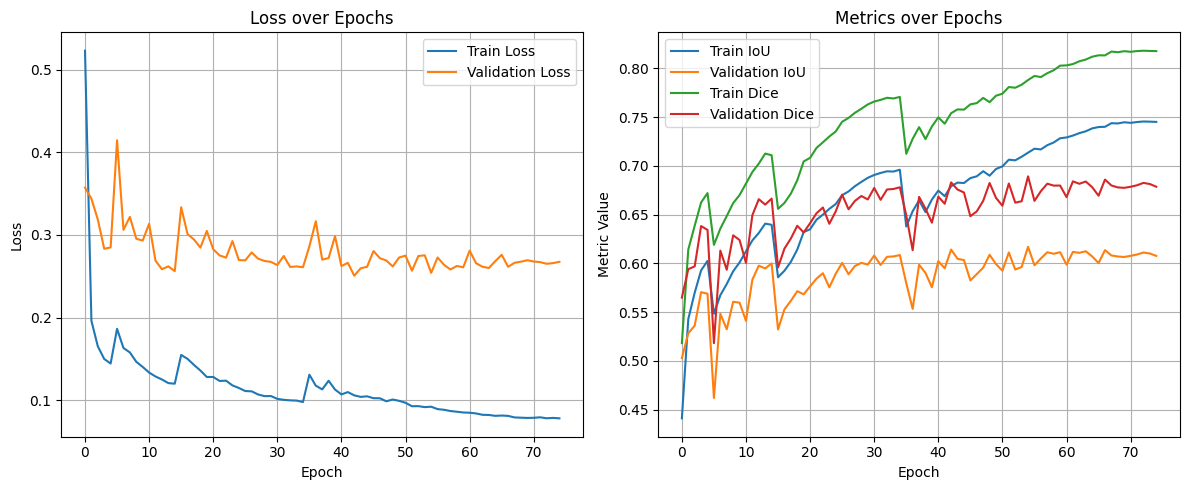

In [ ]:
best_lr = 1.66e-03
best_wd = 7e-05

print("--- 3단계: 최종 학습을 시작합니다 ---")
print(f"사용할 하이퍼파라미터: LR={best_lr:.6f}, WD={best_wd:.6f}")

FINAL_EPOCHS = 75
T_0 = 5 

final_model = CustomModel(dropout_rate=0.5).to(DEVICE)

dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = smp.losses.SoftBCEWithLogitsLoss()
criterion = lambda logits, masks: dice_loss(logits, masks) + bce_loss(logits, masks)

optimizer = optim.AdamW(final_model.parameters(), lr=best_lr, weight_decay=best_wd)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0 * len(train_loader), T_mult=2)

best_iou = 0.0
best_dice = 0.0

history = {
    'train_loss': [],
    'train_iou': [],
    'train_dice': [],
    'val_loss': [],
    'val_iou': [],
    'val_dice': []
}

for epoch in range(1, FINAL_EPOCHS + 1):
    print(f"\n--- 최종 학습 Epoch {epoch}/{FINAL_EPOCHS} ---")
    
    train_loss, train_iou, train_dice = train_one_epoch(final_model, train_loader, optimizer, scheduler, criterion, DEVICE)
    val_loss, val_iou, val_dice = validate(final_model, test_loader, criterion, DEVICE)

    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    history['val_dice'].append(val_dice)

    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f}"
          f"\nValid Loss: {val_loss:.4f}, Valid IoU: {val_iou:.4f}, Valid Dice: {val_dice:.4f}")

    if val_dice > best_dice:
        best_iou = val_iou
        best_dice = val_dice 
        torch.save(final_model.state_dict(), 'best_model.pth')
        print(f"  >> 새로운 최고 성능 달성! (IoU: {best_iou:.4f} / Dice: {best_dice:.4f}). 'best_model.pth'에 모델을 저장합니다.")


print("\n--- 최종 학습 완료 ---")

print(f"최고 검증 IoU: {best_iou:.4f}")
print(f"최고 검증 Dice: {best_dice:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_iou'], label='Train IoU')
plt.plot(history['val_iou'], label='Validation IoU')
plt.plot(history['train_dice'], label='Train Dice')
plt.plot(history['val_dice'], label='Validation Dice')
plt.title('Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()